In [2]:
# pandas, numpy, seaborn, matplotlib, matplotlib의 패치, functools를 import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from matplotlib import font_manager, rc
from functools import reduce

# pandas의 옵션 중, 데이터프레임이 최대로 출력되는 행의 수를 1500으로 설정
pd.options.display.max_rows = 1500

# 한글 폰트 파일 경로를 지정하고, 폰트 이름을 가져온다.
font_path = './data/malgun.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()

# 폰트 이름을 사용하여 matplotlib의 폰트 설정
rc('font', family=font_name)

# matplotlib에서 유니코드 마이너스 기호를 제대로 표시하기 위해 설정
mpl.rcParams['axes.unicode_minus'] = False


In [3]:
# DataFrame에서 특정 column을 제거하는 함수
def drop_column(df, column):
    # DataFrame에서 해당 column을 제거하고, DataFrame 자체를 수정
    result = df.drop(column, axis=1, inplace=True)
    # 수정된 DataFrame을 반환
    return result

# DataFrame에서 특정 row (index)을 제거하는 함수
def drop_index(df, index):
    # DataFrame에서 해당 row를 제거하고, DataFrame 자체를 수정
    result = df.drop(index, axis=0, inplace=True)
    # 수정된 DataFrame을 반환
    return result

# DataFrame에서 특정 column을 정규화하는 함수
def normalize(df, column):
    # 해당 column을 min-max scaling 방식으로 정규화
    result = (df[column]-df[column].min())/(df[column].max()-df[column].min())
    # 정규화된 column을 반환
    return result

# 여러 개의 DataFrame을 공통 column을 기준으로 병합하는 함수
def merge_df(df_list:list, merge_option:str, column:str):
    # reduce를 사용하여 df_list 내의 모든 DataFrame을 공통 column을 기준으로 merge_option에 따라 병합
    result = reduce(lambda x, y : pd.merge(x,y, how=merge_option, on=column), df_list)
    # 병합된 DataFrame을 반환
    return result


In [4]:
# get_all_df 함수: eth_price.csv, kospi_price.csv, nasdaq_price.csv 파일을 읽어서 모두 병합한 DataFrame을 반환하는 함수
def get_all_df():
    # 각각의 csv 파일을 DataFrame으로 읽어온다.
    eth_df = pd.read_csv("./data/eth_price.csv")
    kospi_df = pd.read_csv("./data/kospi_price.csv")
    nasdaq_df = pd.read_csv("./data/nasdaq_price.csv")

    # 'symbol' column을 각각의 DataFrame에서 제거
    drop_column(eth_df, 'symbol')
    drop_column(kospi_df, 'symbol')
    drop_column(nasdaq_df, 'symbol')

    # 병합을 위해 DataFrame 리스트를 만듭니다.
    df_list = [eth_df, kospi_df, nasdaq_df]
    # 공통 column 'date'를 기준으로 모든 DataFrame을 병합
    all_df = merge_df(df_list, 'outer', 'date')
    # 'date' column을 datetime 형식으로 변환하고, 날짜 정보만 남긴다.
    all_df["date"] = pd.to_datetime(all_df["date"]).dt.date
    # 날짜순으로 정렬
    all_df = all_df.sort_values(by="date")
    # 'date' column을 인덱스로 설정
    all_df = all_df.set_index("date")
    # 병합된 DataFrame을 반환
    return all_df

# get_normalize_df 함수: get_all_df 함수로부터 병합된 DataFrame을 받아 각 column을 정규화한 새로운 DataFrame을 반환하는 함수
def get_normalize_df():
    # get_all_df 함수를 사용하여 모든 DataFrame을 병합한 DataFrame을 얻는다.
    all_df = get_all_df()
    # 각 column을 정규화
    all_df["eth_price_norm"] = normalize(all_df, "eth_price")
    all_df["kospi_price_norm"] = normalize(all_df, "kospi_price")
    all_df["nasdaq_price_norm"] = normalize(all_df, "nasdaq_price")
    # 정규화된 DataFrame을 반환
    return all_df


In [5]:
class StockCoinDashBoard:
    
    def __init__(self, df):
        self.df = df
    
    #년도별 그래프
    def year_plot_graph(self):
        all_norm_df = self.df
        fig = plt.figure(figsize=(30,20))
        plot_1 = fig.add_subplot(211)
        plot_2 = fig.add_subplot(212)

    #---------------첫번째 그래프--------------
        df_list = all_norm_df[['eth_price','kospi_price', 'nasdaq_price']]
        plot_1.plot(df_list, label=['eth_price','kospi_price', 'nasdaq_price'])
        plot_1.legend(loc="best")
        plot_1.set_xlabel('DATE', fontsize = 15) # x축 이름
        plot_1.set_ylabel('PRICE', fontsize = 15)  # y축 이름
        plot_1.set_title('년도별 그래프', fontsize=15)
    #---------------두번째 그래프--------------
        norm_df_list = all_norm_df[['eth_price_norm','kospi_price_norm', 'nasdaq_price_norm']]
        plot_2.plot(norm_df_list, label=['eth_price_norm','kospi_price_norm', 'nasdaq_price_norm'])
        plot_2.legend(loc="best")
        plot_2.set_xlabel('DATE', fontsize = 15) # x축 이름
        plot_2.set_ylabel('PRICE', fontsize = 15)  # y축 이름
        plot_2.set_title('년도별 그래프(정규화)', fontsize=15)
        plt.tight_layout()
        plt.show()

    #월별 그래프
    def month_plot_graph(self):
        all_norm_df = self.df
        all_norm_df = all_norm_df.reset_index()
        all_norm_df['date']= pd.to_datetime(all_norm_df['date'])
        all_norm_df["월"] = all_norm_df["date"].dt.month
        all_norm_df = all_norm_df.set_index("date")
        all_norm_df = all_norm_df[['kospi_price','nasdaq_price','월']].dropna()
    #---------------정규화--------------
        month_df = all_norm_df.groupby(by=["월"]).mean()
        month_df["kospi_price_norm"] = normalize(month_df, "kospi_price")
        month_df["nasdaq_price_norm"] = normalize(month_df, "nasdaq_price")
    #---------------월별 그래프--------------
        plt.figure(figsize=(25,8))
        plt.plot(month_df[['kospi_price_norm', 'nasdaq_price_norm']], label=['kospi_price_norm', 'nasdaq_price_norm'])
        plt.xticks(np.arange(1,13))
        plt.xlabel('DATE', fontsize = 15) # x축 이름
        plt.ylabel('PRICE', fontsize = 15)  # y축 이름
        plt.title('월별 그래프(정규화)', fontsize=15)
        plt.legend()
        plt.show()

    #요일별 그래프
    def days_plot_graph(self):
    #---------------첫번째 그래프--------------
        all_norm_df = self.df
        all_norm_df = all_norm_df.reset_index()
        all_norm_df['date']= pd.to_datetime(all_norm_df['date'])
        all_norm_df["요일"] = all_norm_df["date"].dt.dayofweek
        all_norm_df = all_norm_df.set_index("date")
        all_norm_df = all_norm_df[['eth_price','kospi_price','nasdaq_price','요일']].dropna()
        #days_df.drop(["eth_price_norm","kospi_price_norm","nasdaq_price_norm","월"], axis=1)
    #---------------정규화--------------
        days_df = all_norm_df.groupby(by=["요일"]).mean()
        days_df.index=["월요일","화요일","수요일","목요일","금요일"]
        days_df["eth_price_norm"] = normalize(days_df, "eth_price")
        days_df["kospi_price_norm"] = normalize(days_df, "kospi_price")
        days_df["nasdaq_price_norm"] = normalize(days_df, "nasdaq_price")
        plt.figure(figsize=(25,8))
        plt.plot(days_df[['eth_price_norm','kospi_price_norm', 'nasdaq_price_norm']], label=['eth_price_norm','kospi_price_norm', 'nasdaq_price_norm'])
        plt.xlabel('DATE', fontsize = 15) # x축 이름
        plt.ylabel('PRICE', fontsize = 15)  # y축 이름
        plt.title('요일별 그래프(정규화)', fontsize=15)
        plt.legend()
        plt.show()
            
    # 코스피 & 나스닥 & 이더리움 상관관계 분석
    # (shift: 0 => 단기 / 장기투자 확인, shift: 1 => 코스닥 / 나스닥 하루치 영향 관계)
    # (periods: 100 => 100일과의 퍼센트를 비교한다.)
    def scatter_plot_graph(self, days:int, periods:int, limit:int, add=None):
        all_norm_df = self.df
        all_df = all_norm_df.iloc[:,0:3]
    #---------------첫번째 그래프--------------
        if not add:
            all_df["kospi_price"] = all_df["kospi_price"].shift(days)
            all_df = all_df.dropna()
            all_df = all_df.pct_change(periods=periods)*100
            all_df = all_df.dropna()
            if days < 0:
                scatter_plot = sns.scatterplot(data=all_df, x="kospi_price" ,y="nasdaq_price")
                scatter_plot.set(xlim=(-limit,limit))
                scatter_plot.set(ylim=(-limit,limit))
            else:
                scatter_plot = sns.scatterplot(data=all_df, x="nasdaq_price" ,y="kospi_price")
                scatter_plot.set(xlim=(-limit,limit))
                scatter_plot.set(ylim=(-limit,limit))
    #---------------두번째 그래프--------------
        if add == "ETH":
            all_df["eth_price"]= all_df["eth_price"].shift(days)
            all_df= all_df.dropna()
            all_df= all_df.pct_change(periods=periods)*100
            all_df= all_df.dropna()
    #---------------이상치 제거--------------
            q1=all_df["eth_price"].quantile(0.05)
            q3=all_df["eth_price"].quantile(0.95)
            iqr=q3-q1
            all_df["eth_price"] = np.where(all_df["eth_price"] > q3, q3, all_df["eth_price"])
            all_df["eth_price"] = np.where(all_df["eth_price"] < q1, q1, all_df["eth_price"])

            scatter_plot = sns.scatterplot(data=all_df, x="nasdaq_price" ,y="kospi_price", hue="eth_price")
            scatter_plot.set(xlim=(-limit,limit))
            scatter_plot.set(ylim=(-limit,limit))
            
    def box_plot_graph(self):
        all_df = self.df
        all_df= all_df.dropna()
        all_df= (all_df.pct_change()*100).abs() # 하루차의 퍼센트
        all_df= all_df.dropna()
        all_df = all_df.reset_index()
        all_df['date'] = pd.to_datetime(all_df['date'])
        all_df['date'] = all_df['date'].dt.year

        kospi_mean_price = all_df.groupby('date')['kospi_price'].mean()
        eth_mean_price = all_df.groupby('date')['eth_price'].mean()
        nasdaq_mean_price = all_df.groupby('date')['nasdaq_price'].mean()

        all_mean_df = pd.concat([eth_mean_price, kospi_mean_price, nasdaq_mean_price],axis=1)
        all_mean_df = all_mean_df.iloc[:6,:] #2023년 제외

        all_mean_df.boxplot(by='date')
        plt.show()
            

    # FOMC 전날 대비 변화률 비교 
    def bar_plot_graph(self):
    #---------------fomc 전처리--------------
        fomc_df = pd.read_csv("./data/fomc_date.csv")
        fomc_df["confirm"] = "o"
        drop_column(fomc_df, 'symbol')
        fomc_df['date'] = fomc_df['date'].astype("str")
        
        all_df = self.df
        all_df= all_df.dropna()
        all_df= (all_df.pct_change()*100).abs() # 하루차의 퍼센트
        all_df= all_df.dropna()
        all_df = all_df.reset_index()
        all_df['date'] = all_df['date'].astype("str")
        
        all_fomc_df= pd.merge(all_df, fomc_df , how="outer" ,on="date")
        all_fomc_df= all_fomc_df.dropna(subset=["eth_price","kospi_price","nasdaq_price"])
        all_fomc_df = all_fomc_df.set_index("date")
        all_fomc_df[['eth_ratio_fore','kospi_ratio_fore','nasdaq_ratio_fore']] = all_fomc_df[["eth_price","kospi_price","nasdaq_price"]].shift(-1)
        all_fomc_df= all_fomc_df.dropna(subset=["eth_price","kospi_price","nasdaq_price", "confirm"])
        all_fomc_df = all_fomc_df.rename(columns={"eth_price": "eth_ratio_pre", "nasdaq_price": "nasdaq_ratio_pre", "kospi_price" : "kospi_ratio_pre"})
        drop_column(all_fomc_df, 'confirm')
        
        all_fomc_list = list(all_fomc_df.mean())
        data = {"eth_ratio": [all_fomc_list[0],all_fomc_list[3]],
                "kospi_ratio": [all_fomc_list[1],all_fomc_list[4]],
                "nasdaq_ratio": [all_fomc_list[2],all_fomc_list[5]]}
        all_fomc_graph_df = pd.DataFrame( data=data, index=["pre","fore"])
        all_fomc_graph_df = all_fomc_graph_df.transpose()
    #---------------그래프--------------
        all_fomc_graph_df.plot.bar(rot=0)
    #---------------화살표 위치--------------
        eth_arrow=pat.FancyArrowPatch((-0.2, 3.3), (-0.05, 4.2), mutation_scale=20,color="green", fill=True)
        plt.gca().add_patch(eth_arrow)
        kospi_arrow=pat.FancyArrowPatch((0.8, 0.67), (0.95, 0.91), mutation_scale=20,color="green", fill=True)
        plt.gca().add_patch(kospi_arrow)
        nasdaq_arrow=pat.FancyArrowPatch((2, 1.45), (2.15, 1.1), mutation_scale=20,color="red", fill=True)
        plt.gca().add_patch(nasdaq_arrow)
    #---------------퍼센트 값--------------
        eth_perc = str(round((all_fomc_list[3]/all_fomc_list[0])*100-100))+"%"
        kospi_perc = str(round((all_fomc_list[4]/all_fomc_list[1])*100-100))+"%"
        nasdaq_perc = str(round((all_fomc_list[5]/all_fomc_list[2])*100-100))+"%"
    #---------------퍼센트 위치--------------
        plt.text(0.1, 4.25, eth_perc, ha="center")
        plt.text(1.1, 0.95, kospi_perc, ha="center")
        plt.text(2.1, 1.5, nasdaq_perc, ha="center")
        
        plt.show()        

연도별 그래프 분석

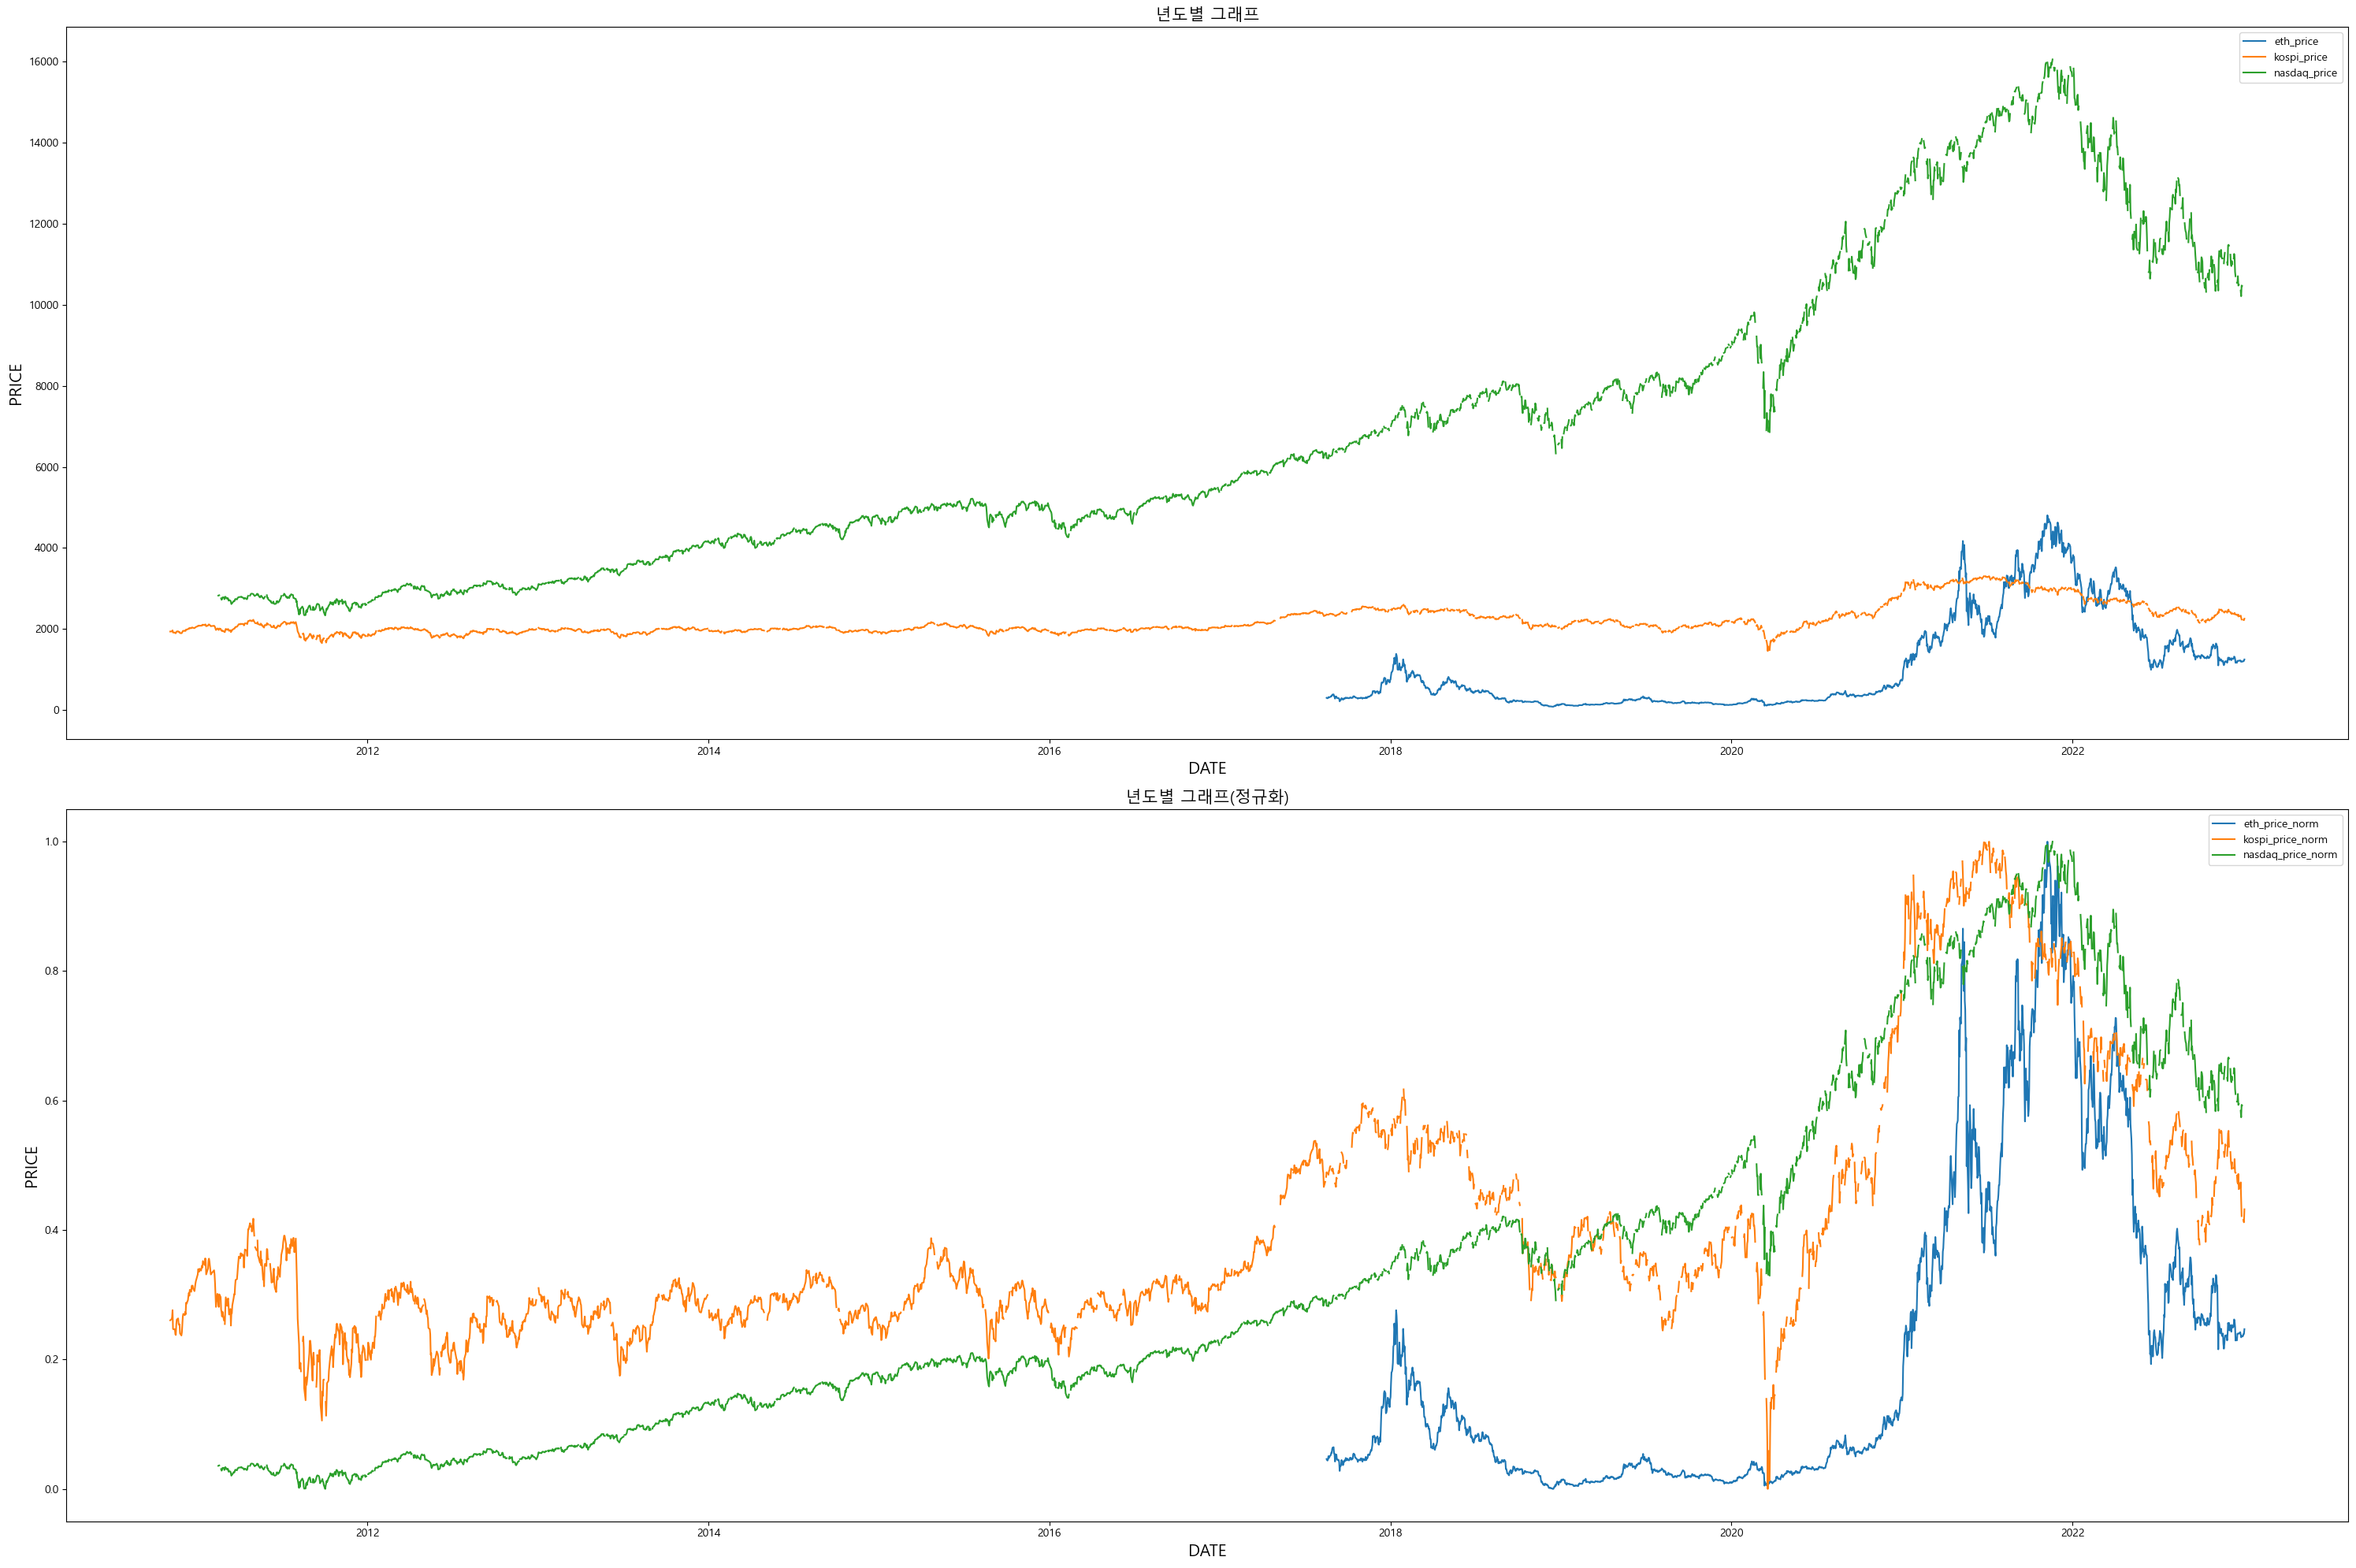

In [398]:
df = get_normalize_df()
dashboard = StockCoinDashBoard(df)
dashboard.year_plot_graph()

월별 그래프 분석

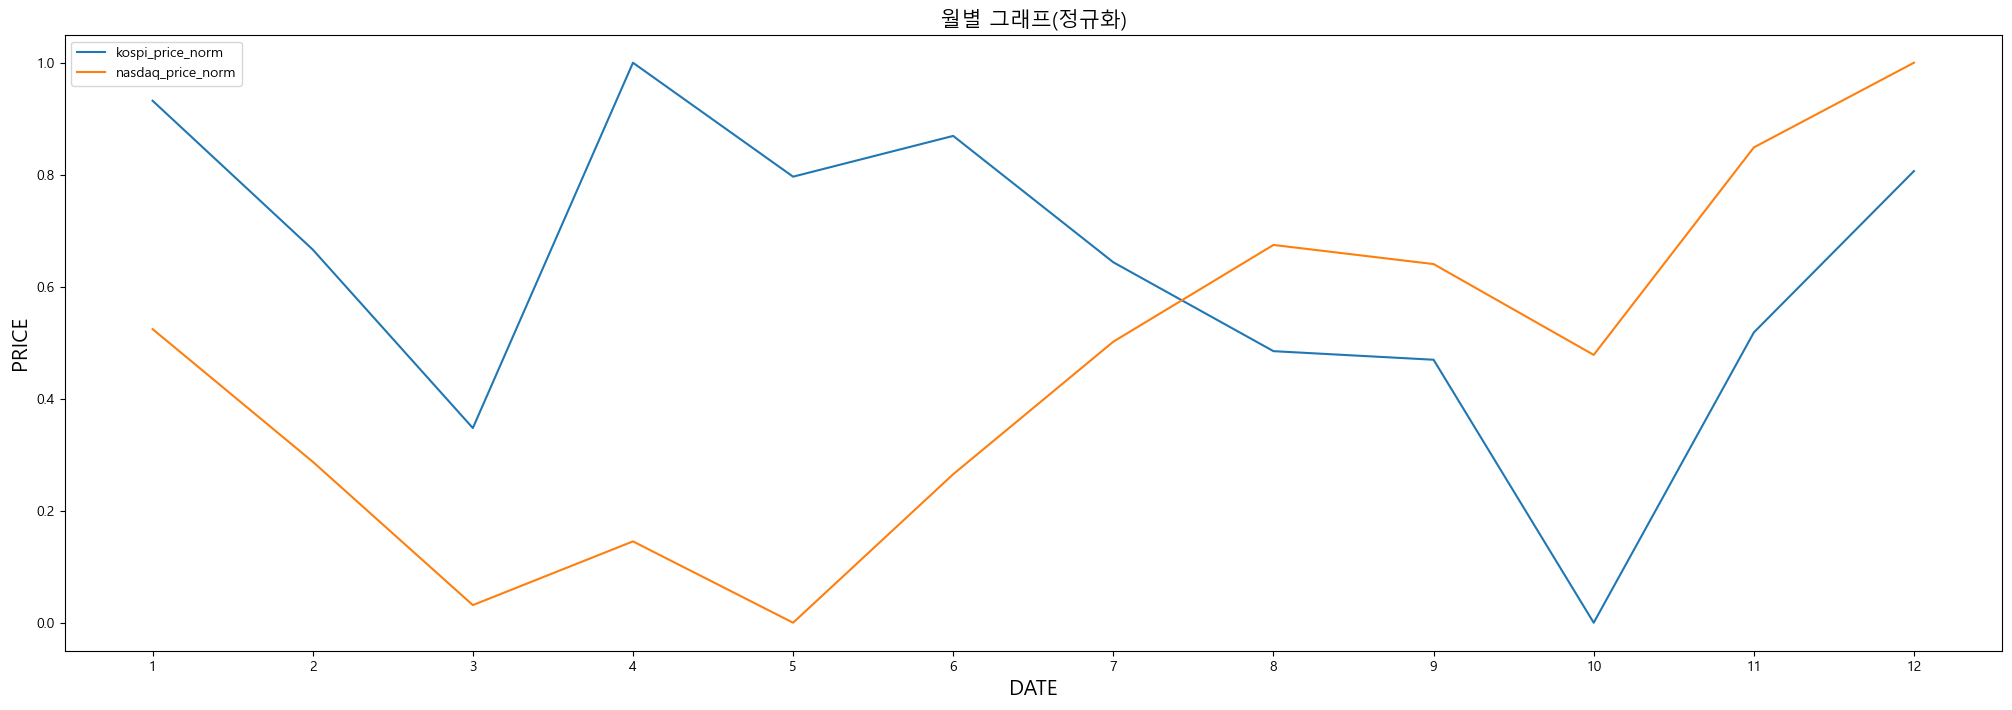

,kospi_price,nasdaq_price,kospi_price_norm,nasdaq_price_norm
월,,,,
1,2226.711302,6917.229116,0.932140,0.524338
2,2208.266158,6743.100788,0.666374,0.287501
3,2186.146877,6554.864743,0.347669,0.031476
4,2231.421025,6638.512992,1.000000,0.145248
5,2217.298421,6531.722939,0.796515,0.000000
6,2222.351230,6726.704713,0.869318,0.265200
7,2206.687233,6900.714822,0.643624,0.501877
8,2195.672392,7027.707294,0.484917,0.674603
9,2194.610045,7002.596561,0.469610,0.640449


In [365]:
df = get_normalize_df()
dashboard = StockCoinDashBoard(df)
dashboard.month_plot_graph()

요일별 그래프 분석

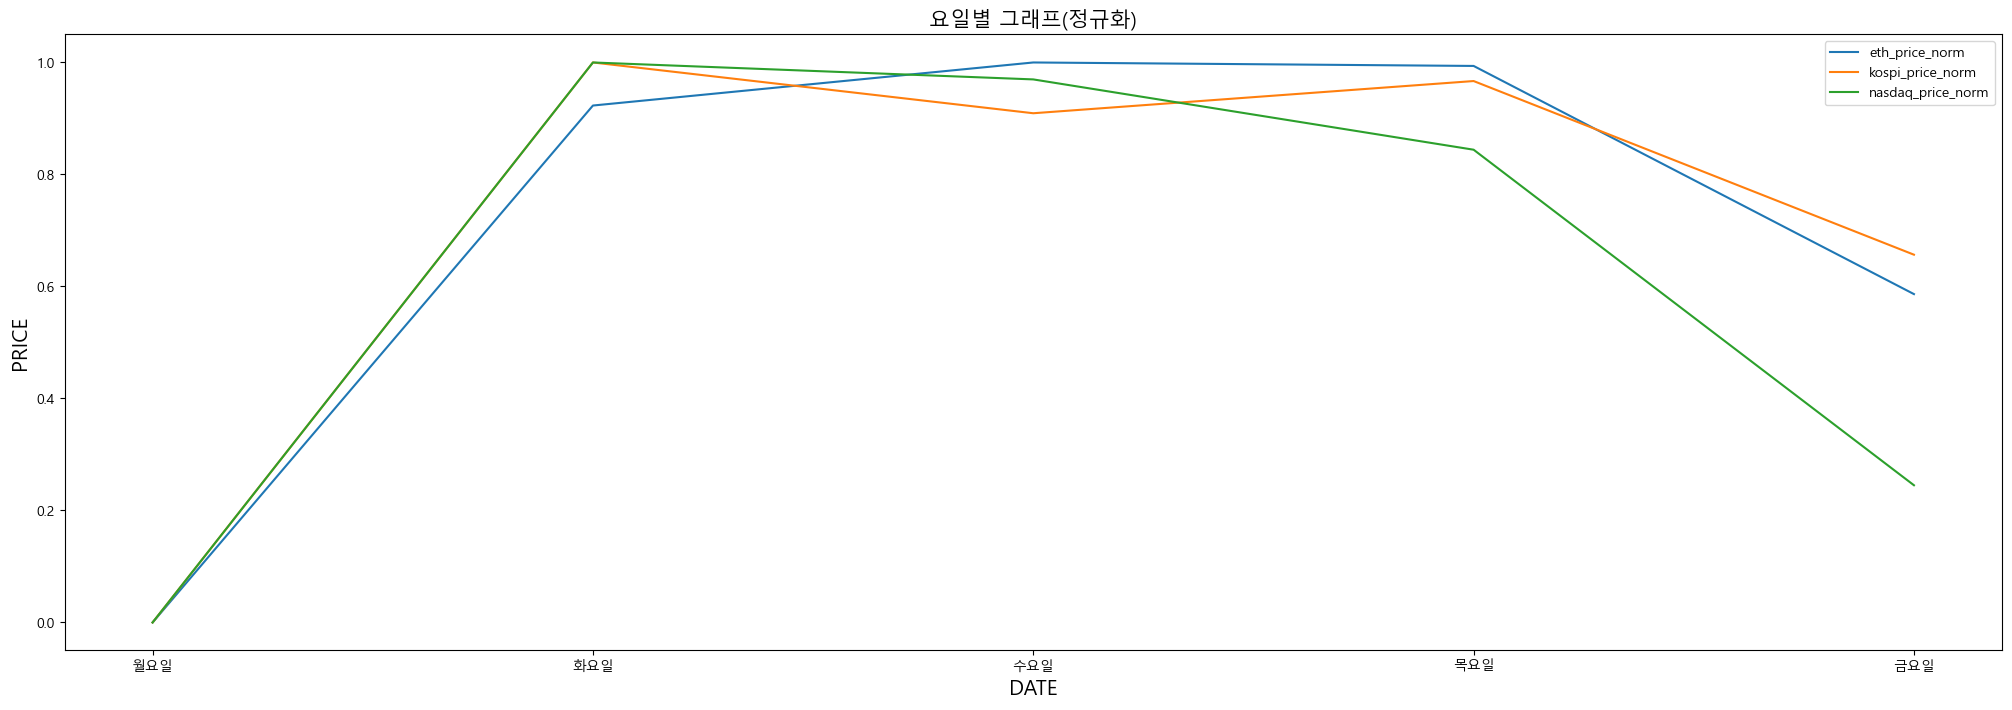

In [111]:
df = get_normalize_df()
dashboard = StockCoinDashBoard(df)
dashboard.days_plot_graph()

코스피 & 나스닥 & 이더리움 상관관계 분석

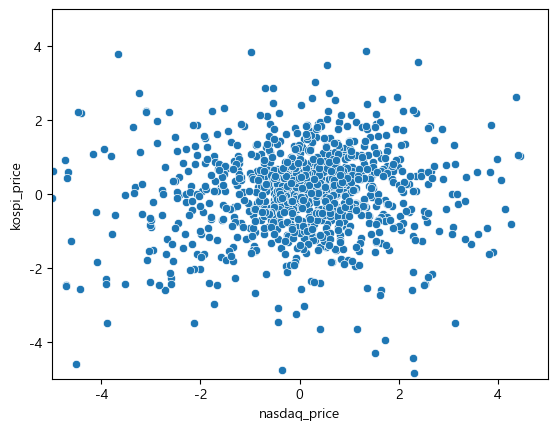

In [21]:
df = get_normalize_df()
dashboard = StockCoinDashBoard(df)
#ex) 나스닥 19일과 코스피 20일 - 하루간격의 서로 영향 관계
dashboard.scatter_plot_graph(1, 1, 5)

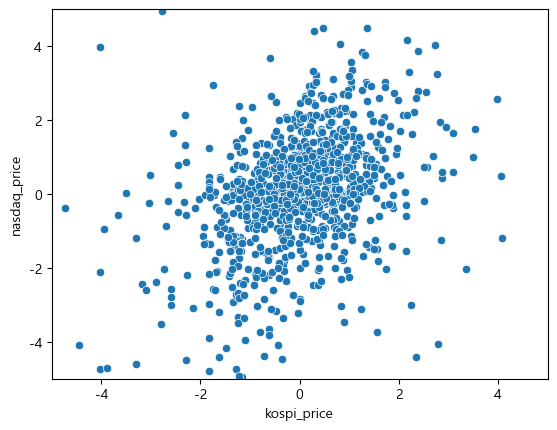

In [75]:
#ex) 코스피 19일과 나스닥 20일 - 하루간격의 서로 영향 관계
dashboard.scatter_plot_graph(-1, 1, 5)

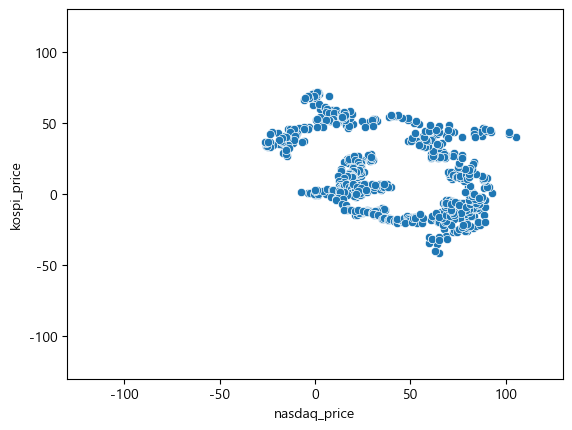

In [41]:
#ex) 코스피 & 나스닥 1년치를 비교 - 단기 / 장기투자 확인
dashboard.scatter_plot_graph(days=365, periods=365, limit=130)

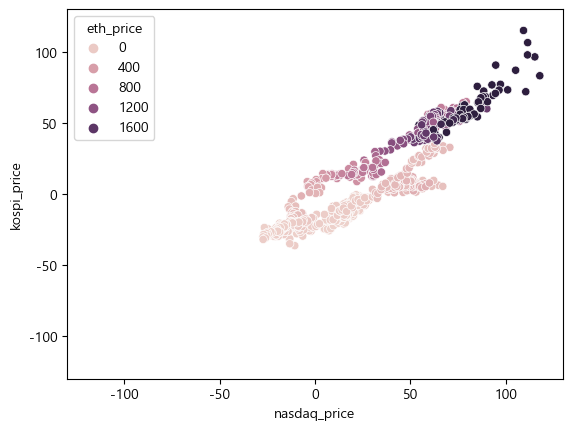

In [62]:
#ex) 코스피 & 나스닥 & 이더리움 1년치를 비교 - 단기 / 장기투자 확인
dashboard.scatter_plot_graph(days=0, periods=365, limit=130, add='ETH')

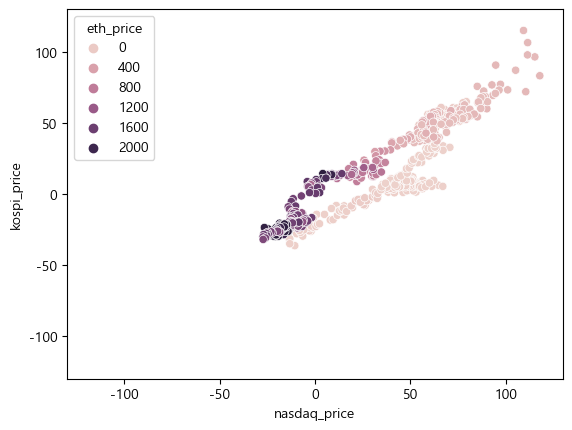

In [61]:
dashboard.scatter_plot_graph(days=365, periods=365, limit=130, add='ETH')

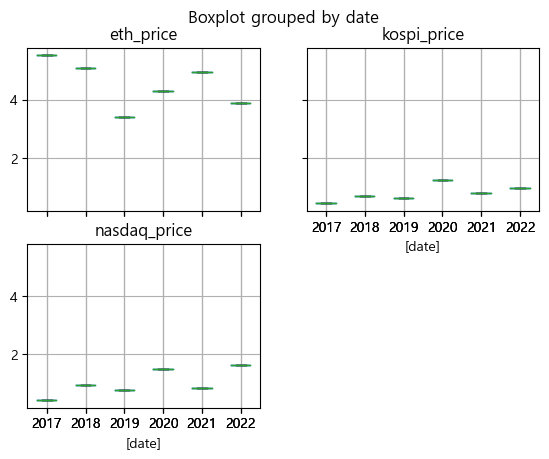

In [6]:
df = get_normalize_df()
dashboard = StockCoinDashBoard(df)
dashboard.box_plot_graph()


FOMC 날짜 대비 전날에서 당일날 / 당일날에서 다음날 

ex) FOMC 발표날 20일
pre 19~20
fore 20~21

pre와 fore을 비교했을 때 변동률 변화 확인

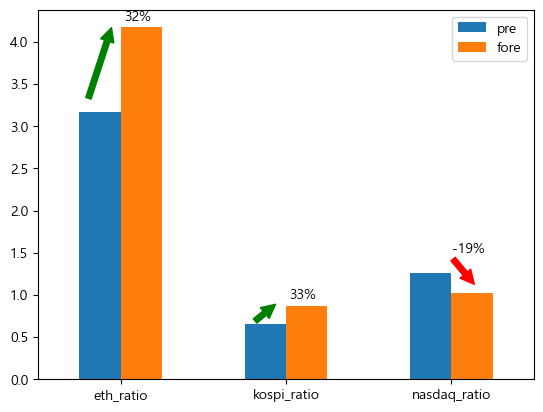

In [100]:
df = get_all_df()
dashboard = StockCoinDashBoard(df)
dashboard.bar_plot_graph()